In [1]:
!python -V

Python 3.12.1


In [2]:
import mlflow
import os
import boto3
from dotenv import load_dotenv

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR
from sklearn.metrics import root_mean_squared_error

import xgboost as xgb

In [3]:
os.environ["AWS_PROFILE"] = "user1" # fill in with your AWS profile. More info: https://docs.aws.amazon.com/sdk-for-java/latest/developer-guide/setup.html#setup-credentials

In [4]:
# Load .env
load_dotenv()

# S3 client
s3 = boto3.client("s3")
bucket = os.getenv("S3_BUCKET_NAME")

print(f"Using bucket: {bucket}")
print(s3.list_objects(Bucket=bucket))

Using bucket: taxi-duration-artifacts
{'ResponseMetadata': {'RequestId': 'SM9SJX6YF2Z6DA1W', 'HostId': 'rbMJ+75YrFYPK13km65bQLvBnNVaAsEg8qMLSsR5PWyy3OKHzZIZmKpsjwgRyQC43xmpf5yx7fVUE/JCc0jVWx4ijEm0CVXt6ffxaviYwWs=', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amz-id-2': 'rbMJ+75YrFYPK13km65bQLvBnNVaAsEg8qMLSsR5PWyy3OKHzZIZmKpsjwgRyQC43xmpf5yx7fVUE/JCc0jVWx4ijEm0CVXt6ffxaviYwWs=', 'x-amz-request-id': 'SM9SJX6YF2Z6DA1W', 'date': 'Sat, 04 Oct 2025 05:16:27 GMT', 'x-amz-bucket-region': 'us-east-2', 'content-type': 'application/xml', 'transfer-encoding': 'chunked', 'server': 'AmazonS3'}, 'RetryAttempts': 0}, 'IsTruncated': False, 'Marker': '', 'Name': 'taxi-duration-artifacts', 'Prefix': '', 'MaxKeys': 1000, 'EncodingType': 'url'}


In [5]:
TRACKING_SERVER_HOST = os.getenv("EC2_PUBLIC_DNS") # fill in with the public DNS of the EC2 instance
mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:5000")

In [6]:
print(f"tracking URI: '{mlflow.get_tracking_uri()}'")

tracking URI: 'http://ec2-3-144-150-8.us-east-2.compute.amazonaws.com:5000'


In [7]:
mlflow.search_experiments() # list_experiments API has been removed, you can use search_experiments instead.()

[<Experiment: artifact_location='s3://taxi-duration-artifacts/2', creation_time=1759554508528, experiment_id='2', last_update_time=1759554508528, lifecycle_stage='active', name='exp_2_linear_models', tags={}>,
 <Experiment: artifact_location='s3://taxi-duration-artifacts/1', creation_time=1759269423243, experiment_id='1', last_update_time=1759269423243, lifecycle_stage='active', name='exp_1_linear_models', tags={}>,
 <Experiment: artifact_location='s3://taxi-duration-artifacts/0', creation_time=1759266677185, experiment_id='0', last_update_time=1759266677185, lifecycle_stage='active', name='Default', tags={}>]

### link to user guide

https://www.nyc.gov/assets/tlc/downloads/pdf/trip_record_user_guide.pdf

### link to data dictionary

https://data.cityofnewyork.us/api/views/hvrh-b6nb/files/65544d38-ab44-4187-a789-5701b114a754?download=true&filename=data_dictionary_trip_records_green.pdf

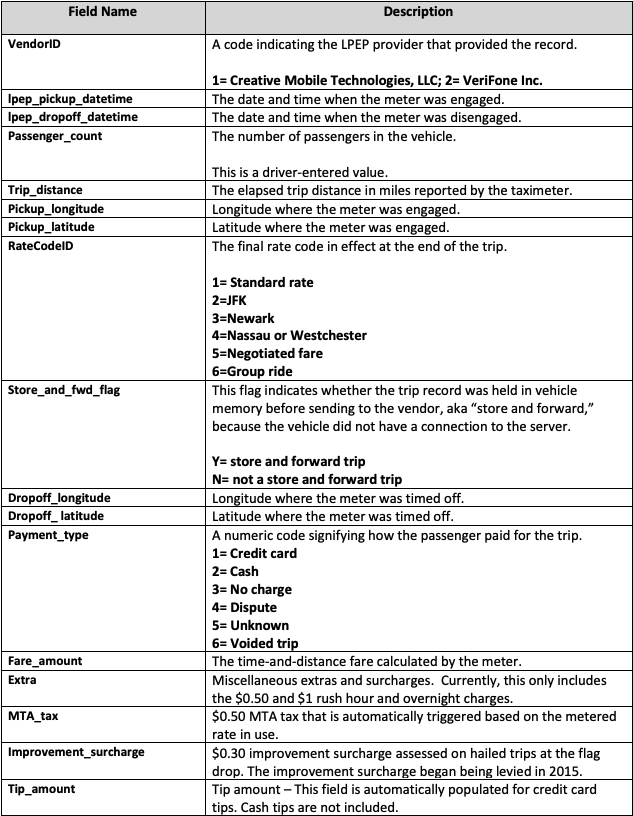
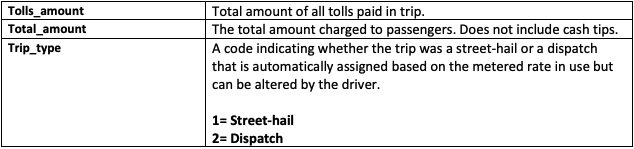


## Preprocessing

In [8]:
def read2df(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)
        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)
    df['PU_DO'] = df['PULocationID'].astype(str) + '_' + df['DOLocationID'].astype(str) #could backfire as it could create combonatorial explosion
    df['pu_hour'] = df['lpep_pickup_datetime'].dt.hour #isolate the hour of the day of pickup
    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime #create response variable
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60) 

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID', 'PU_DO']
    df[categorical] = df[categorical].astype(str) # DictVectorizer inputs dict of strs and outputs numpy array
    
    return df

In [9]:
# now training set will be the month before the validation set
df_train = read2df('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2025-02.parquet')
df_val = read2df('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2025-03.parquet')

In [10]:
len(df_train), len(df_val)

(44218, 48336)

In [11]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance','pu_hour','tolls_amount']

In [12]:
dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)
y_train = df_train['duration'].values

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)
y_val = df_val['duration'].values

## Training Linear Models

In [14]:
mlflow.set_experiment("exp_3_linear_models")

mlflow.sklearn.autolog()

for model_class in (LinearRegression, Lasso, Ridge, ElasticNet):

    with mlflow.start_run():

        mlflow.set_tag('developer','nathaniel')  
     
        mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.csv")
        mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.csv")
        

        mlmodel = model_class()
        mlmodel.fit(X_train, y_train)  

        y_pred = mlmodel.predict(X_val)
        rmse = root_mean_squared_error(y_val, y_pred)
        mlflow.log_metric("rmse", rmse)

        mlflow.sklearn.log_model(mlmodel, artifact_path="models")
        print(f"default artifacts URI: '{mlflow.get_artifact_uri()}'")

2025/10/04 05:18:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 05:18:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


default artifacts URI: 's3://taxi-duration-artifacts/3/081b8d16fdfb4640922afcd81ae7ef3c/artifacts'
🏃 View run unruly-ant-377 at: http://ec2-3-144-150-8.us-east-2.compute.amazonaws.com:5000/#/experiments/3/runs/081b8d16fdfb4640922afcd81ae7ef3c
🧪 View experiment at: http://ec2-3-144-150-8.us-east-2.compute.amazonaws.com:5000/#/experiments/3


2025/10/04 05:18:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 05:18:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


default artifacts URI: 's3://taxi-duration-artifacts/3/4dd641d0172b41c4849739fb2f01a8aa/artifacts'
🏃 View run youthful-zebra-517 at: http://ec2-3-144-150-8.us-east-2.compute.amazonaws.com:5000/#/experiments/3/runs/4dd641d0172b41c4849739fb2f01a8aa
🧪 View experiment at: http://ec2-3-144-150-8.us-east-2.compute.amazonaws.com:5000/#/experiments/3


2025/10/04 05:18:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 05:18:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


default artifacts URI: 's3://taxi-duration-artifacts/3/449dea75cfe749598ab4fc3ae1ce92cf/artifacts'
🏃 View run charming-lamb-843 at: http://ec2-3-144-150-8.us-east-2.compute.amazonaws.com:5000/#/experiments/3/runs/449dea75cfe749598ab4fc3ae1ce92cf
🧪 View experiment at: http://ec2-3-144-150-8.us-east-2.compute.amazonaws.com:5000/#/experiments/3


2025/10/04 05:19:05 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 05:19:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


default artifacts URI: 's3://taxi-duration-artifacts/3/e871806ebc7e4b7db4798cfbbd743500/artifacts'
🏃 View run fortunate-steed-812 at: http://ec2-3-144-150-8.us-east-2.compute.amazonaws.com:5000/#/experiments/3/runs/e871806ebc7e4b7db4798cfbbd743500
🧪 View experiment at: http://ec2-3-144-150-8.us-east-2.compute.amazonaws.com:5000/#/experiments/3


In [15]:
mlflow.search_experiments()

[<Experiment: artifact_location='s3://taxi-duration-artifacts/3', creation_time=1759555032798, experiment_id='3', last_update_time=1759555032798, lifecycle_stage='active', name='exp_3_linear_models', tags={}>,
 <Experiment: artifact_location='s3://taxi-duration-artifacts/2', creation_time=1759554508528, experiment_id='2', last_update_time=1759554508528, lifecycle_stage='active', name='exp_2_linear_models', tags={}>,
 <Experiment: artifact_location='s3://taxi-duration-artifacts/1', creation_time=1759269423243, experiment_id='1', last_update_time=1759269423243, lifecycle_stage='active', name='exp_1_linear_models', tags={}>,
 <Experiment: artifact_location='s3://taxi-duration-artifacts/0', creation_time=1759266677185, experiment_id='0', last_update_time=1759266677185, lifecycle_stage='active', name='Default', tags={}>]

## Training Tree Based Models

In [ ]:
mlflow.set_experiment("exp_4_tree_based_models")

mlflow.sklearn.autolog()

for model_class in (RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor):

    with mlflow.start_run():

        mlflow.set_tag('developer','nathaniel')
    
        mlmodel = model_class()
        mlmodel.fit(X_train, y_train)  

        y_pred = mlmodel.predict(X_val)
        rmse = root_mean_squared_error(y_val, y_pred)
        mlflow.log_metric("rmse", rmse)

        mlflow.sklearn.log_model(mlmodel, artifact_path="models")
        print(f"default artifacts URI: '{mlflow.get_artifact_uri()}'")

2025/10/04 05:25:31 INFO mlflow.tracking.fluent: Experiment with name 'exp_4_tree_based_models' does not exist. Creating a new experiment.


## Training Support Vector Regressor

In [ ]:
mlflow.set_experiment("exp_3_SVR_model")

mlflow.sklearn.autolog()

with mlflow.start_run():

    mlflow.set_tag('developer','nathaniel')

    mlmodel = LinearSVR()
    mlmodel.fit(X_train, y_train)  

    y_pred = mlmodel.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse", rmse)

    mlflow.sklearn.log_model(mlmodel, artifact_path="models")
    print(f"default artifacts URI: '{mlflow.get_artifact_uri()}'")

## Training XGBoost with Hyperopt

In [ ]:
# Hyperopt helps automate the often time-consuming and iterative process of finding the best hyperparameters
# fmin-minimize the output, tpe- is the algorythm which controls the logic,
# hp-methods to define the search space, STATUS_OK- tell hyperopt that the run ran sucessfully,
# keeps track of infomrmation for each run
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
# used to define the range of integer hyperparameters
from hyperopt.pyll import scope

In [ ]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [ ]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = root_mean_squared_error(y_val, y_pred)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [ ]:
# quniform(label, low, high, q) samples discrete values evenly spaced within a defined range.
# It's essentially a uniform distribution where values are rounded to the nearest multiple of 'q'.
# loguniform(label, low, high) samples values such that their logarithms are uniformly distributed within a given range.
# values like 0.001, 0.01, 0.1, and 1 might be geometrically important. 
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)), # depth of tree from 4 to 100
    'learning_rate': hp.loguniform('learning_rate', -3, 0), # exp(-3),exp(0) so 0.05 to 1
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}
# -------------------------------
# Run Hyperopt optimization
# -------------------------------

with mlflow.start_run(run_name="xgboost_hyperopt"):
    best_result = fmin(
        fn=objective,
        space=search_space,
        algo=tpe.suggest,
        max_evals=10, #repeat for 10 runs
        trials=Trials()
    )
    mlflow.log_params(best_result)
print("Best hyperparameters:", best_result)

## After experimentation we found the best producing model. Now I will bin and log hyper-paramenters.

In [ ]:
from mlflow.tracking import MlflowClient

# Initialize the MLflow client
client = MlflowClient()

# Replace 'your_run_id' with the actual ID of your MLflow run
run_id = "4a36fb56d3e44624b321bfbbeb5883e7" 

# Get the run object
run = client.get_run(run_id)

# Access the parameters as a dictionary
parameters_dict = run.data.params

# Print or use the dictionary of parameters
print(parameters_dict)

In [ ]:
mlflow.xgboost.autolog(disable=True)

In [ ]:
#looking on mlflow the best model produced

with mlflow.start_run():
    train = xgb.DMatrix(X_train, label=y_train)
    valid = xgb.DMatrix(X_val, label=y_val)

    #if working with team you will want to log this metadata
    mlflow.set_tag('developer','nathaniel')

    best_params = {
        "learning_rate": 0.2995316814511402,
        "max_depth": 9,
        "min_child_weight": 2.2496085284164358,
        "objective": "reg:linear",
        "reg_alpha": 0.0072839511280222095,
        "reg_lambda": 0.0060976068380801125,
        "seed": 42
    }
    # .logparam only takes on parameter at a time. mlflow.log_params will take the dictionary
    mlflow.log_params(best_params)

    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50
        )
    y_pred = booster.predict(valid)
    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse", rmse)

    with open('models/preprocessor.bin', 'wb') as f_out:
        pickle.dump(dv,f_out)

    mlflow.log_artifact('models/preprocessor.bin', artifact_path='preprocessor')

    mlflow.xgboost.log_model(booster, name='models_mlflow') 

In [ ]:
# from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
# from sklearn.svm import LinearSVR

# mlflow.sklearn.autolog()

# for model_class in (RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, LinearSVR):

#     with mlflow.start_run():

#         mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.csv")
#         mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.csv")
#         mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

#         mlmodel = model_class()
#         mlmodel.fit(X_train, y_train)

#         y_pred = mlmodel.predict(X_val)
#         rmse = root_mean_squared_error(y_val, y_pred)
#         mlflow.log_metric("rmse", rmse)
        